Task 1

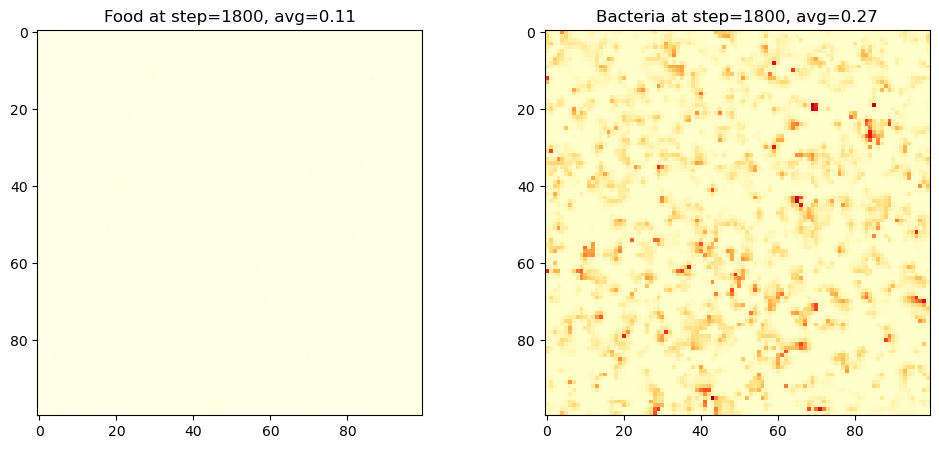

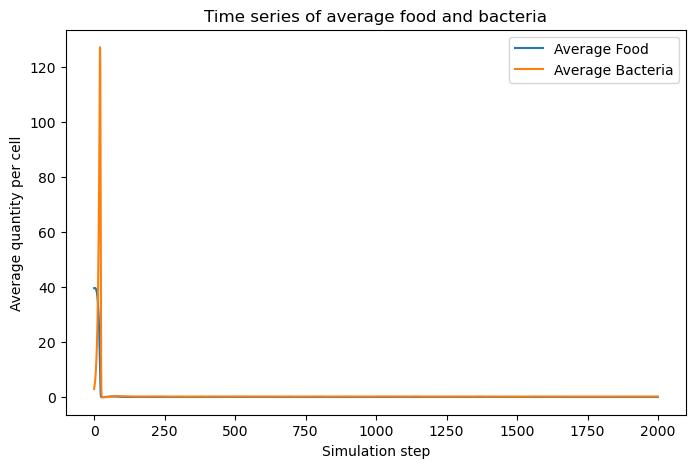

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

# ---- Simulation Parameters ----
GRID_SIZE = 100  # 100x100 grid
INITIAL_FOOD_MEAN = 80.0
INITIAL_BACTERIA_MEAN = 5.0

# Model parameters
g_f = 0.01  # food growth rate
k_f = 100   # food capacity
d_f = 0.1   # food diffusion rate
c_b = 0.05  # bacteria consumption rate
g_b = 0.2   # bacteria growth rate
d_b = 0.1   # bacteria diffusion rate

# Probability of reseeding each cell with 1 unit of food
food_reseed_prob = 0.01

# Number of simulation steps
NUM_STEPS = 2000

# ---- Initialize Grids ----
np.random.seed(42)  # For reproducibility

food_grid = np.random.uniform(
    low=0, high=INITIAL_FOOD_MEAN, size=(GRID_SIZE, GRID_SIZE)
)

bacteria_grid = np.random.uniform(
    low=0, high=INITIAL_BACTERIA_MEAN, size=(GRID_SIZE, GRID_SIZE)
)

def logistic_food_growth(food, g_f, k_f):
    """
    Applies logistic growth to a single cell's food quantity.
    """
    return food + g_f * food * (1 - (food / k_f))

def diffuse(grid, d_rate):
    """
    Diffuse the grid at rate d_rate using Von Neumann neighborhood.
    Each cell sends out d_rate * grid[x,y] (equally among the 4 neighbors).
    """
    new_grid = (1 - d_rate) * grid.copy()
    
    # Shift up/down/left/right and add fraction to each neighbor
    up    = np.roll(grid, -1, axis=0)
    down  = np.roll(grid, 1, axis=0)
    left  = np.roll(grid, 1, axis=1)
    right = np.roll(grid, -1, axis=1)
    
    # Each neighbor receives (d_rate / 4) * neighbor_content
    new_grid += (d_rate / 4) * up
    new_grid += (d_rate / 4) * down
    new_grid += (d_rate / 4) * left
    new_grid += (d_rate / 4) * right
    
    return new_grid

def simulate_step(food_grid, bacteria_grid):
    """
    Perform one simulation step in the specified order:
    1) logistic food growth
    2) food reseeding
    3) food diffusion
    4) consumption
    5) starvation
    6) reproduction
    7) bacteria diffusion
    Returns new (food_grid, bacteria_grid).
    """
    # 1) Food growth
    food_grid_next = logistic_food_growth(food_grid, g_f, k_f)
    
    # Ensure it doesn’t exceed capacity k_f numerically, if needed:
    food_grid_next = np.minimum(food_grid_next, k_f)
    
    # 2) Food reseeding
    random_matrix = np.random.rand(GRID_SIZE, GRID_SIZE)
    reseed_mask = (random_matrix < food_reseed_prob)
    food_grid_next[reseed_mask] += 1.0
    # Clip again to k_f
    food_grid_next = np.minimum(food_grid_next, k_f)
    
    # 3) Food diffusion
    food_grid_next = diffuse(food_grid_next, d_f)
    
    # 4) Bacteria consumption
    # Bacteria in each cell require c_b * B. If not enough food, only part of them survive.
    required_food = c_b * bacteria_grid
    enough_food_mask = (food_grid_next >= required_food)
    
    # The fraction of bacteria that survives in the cells that don't have enough food:
    fraction_surviving = np.where(
        enough_food_mask,
        1.0,  # all survive where there's enough food
        food_grid_next / np.maximum(required_food, 1e-12)  # fraction can survive
    )
    
    # The surviving bacteria
    bacteria_surviving = bacteria_grid * fraction_surviving
    
    # Subtract consumed food
    food_consumed = c_b * bacteria_surviving
    food_grid_after_consumption = food_grid_next - food_consumed
    
    # 5) Starvation: (already handled by fraction_surviving)
    # 6) Reproduction
    bacteria_after_reproduction = bacteria_surviving * (1 + g_b)
    
    # 7) Bacteria diffusion
    bacteria_after_diffusion = diffuse(bacteria_after_reproduction, d_b)
    
    return food_grid_after_consumption, bacteria_after_diffusion

# ---- Run the Simulation ----
food_history = []
bacteria_history = []

for step in range(NUM_STEPS):
    food_grid, bacteria_grid = simulate_step(food_grid, bacteria_grid)
    
    # Track the average quantity over the grid for plotting
    avg_food = np.mean(food_grid)
    avg_bacteria = np.mean(bacteria_grid)
    food_history.append(avg_food)
    bacteria_history.append(avg_bacteria)
    
    # Example: Plot every 200 steps
    if step % 200 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(12,5))
        ax[0].imshow(food_grid, cmap='YlGn', vmin=0, vmax=k_f)
        ax[0].set_title(f"Food at step={step}, avg={avg_food:.2f}")
        ax[1].imshow(bacteria_grid, cmap='YlOrRd')
        ax[1].set_title(f"Bacteria at step={step}, avg={avg_bacteria:.2f}")
        plt.show()

# Final time-series plot
plt.figure(figsize=(8,5))
plt.plot(food_history, label="Average Food")
plt.plot(bacteria_history, label="Average Bacteria")
plt.xlabel("Simulation step")
plt.ylabel("Average quantity per cell")
plt.title("Time series of average food and bacteria")
plt.legend()
plt.show()


Task 2: Empirical Analysis

/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_19782/3746104800.py:14: RuntimeWarning: overflow encountered in multiply
  food_grid = food_grid + g_f * food_grid * (1 - (food_grid / k_f))
/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_19782/3746104800.py:33: RuntimeWarning: overflow encountered in multiply
  bac_surviving = bacteria_grid * fraction_surviving
/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_19782/3746104800.py:31: RuntimeWarning: overflow encountered in divide
  food_grid / np.maximum(required_food, 1e-12)
/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_19782/3746104800.py:31: RuntimeWarning: invalid value encountered in divide
  food_grid / np.maximum(required_food, 1e-12)


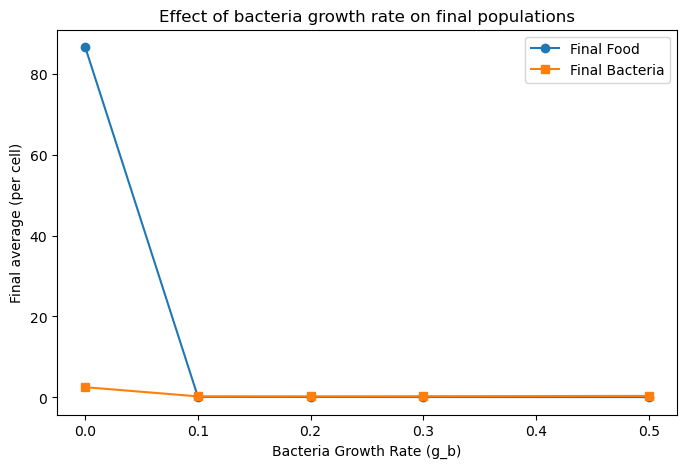

In [2]:
def run_simulation(
    g_f=0.01, k_f=100, d_f=0.1, c_b=0.05, g_b=0.2, d_b=0.1,
    steps=2000, seed=42
):
    np.random.seed(seed)
    food_grid = np.random.uniform(low=0, high=80, size=(GRID_SIZE, GRID_SIZE))
    bacteria_grid = np.random.uniform(low=0, high=5, size=(GRID_SIZE, GRID_SIZE))
    
    food_hist = []
    bac_hist = []
    
    for s in range(steps):
        # 1) logistic food growth
        food_grid = food_grid + g_f * food_grid * (1 - (food_grid / k_f))
        food_grid = np.minimum(food_grid, k_f)
        
        # 2) food reseeding
        reseed_mask = (np.random.rand(GRID_SIZE, GRID_SIZE) < 0.01)
        food_grid[reseed_mask] += 1.0
        food_grid = np.minimum(food_grid, k_f)
        
        # 3) food diffusion
        food_grid = diffuse(food_grid, d_f)
        
        # 4) consumption
        required_food = c_b * bacteria_grid
        enough_food_mask = (food_grid >= required_food)
        fraction_surviving = np.where(
            enough_food_mask,
            1.0,
            food_grid / np.maximum(required_food, 1e-12)
        )
        bac_surviving = bacteria_grid * fraction_surviving
        food_grid -= c_b * bac_surviving
        
        # 6) reproduction
        bac_surviving *= (1 + g_b)
        
        # 7) bacteria diffusion
        bacteria_grid = diffuse(bac_surviving, d_b)
        
        food_hist.append(np.mean(food_grid))
        bac_hist.append(np.mean(bacteria_grid))
    
    return food_hist, bac_hist

# Example: Vary the bacteria growth rate g_b
gb_values = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7]
final_food = []
final_bact = []

for val in gb_values:
    food_hist, bac_hist = run_simulation(g_b=val)
    final_food.append(food_hist[-1])
    final_bact.append(bac_hist[-1])

plt.figure(figsize=(8,5))
plt.plot(gb_values, final_food, 'o-', label="Final Food")
plt.plot(gb_values, final_bact, 's-', label="Final Bacteria")
plt.xlabel("Bacteria Growth Rate (g_b)")
plt.ylabel("Final average (per cell)")
plt.title("Effect of bacteria growth rate on final populations")
plt.legend()
plt.show()




# Bacteria Growth Simulation

**Author:** (Your Name)  
**Date:** (Date)

## Introduction

This report implements and analyzes the bacteria–food growth model described in the PDF document. The system is represented by two 2D grids (each at least \(100\times 100\)):

1. A **food grid** \((F)\) that tracks the amount of food in each cell.
2. A **bacteria grid** \((B)\) that tracks the population of bacteria in each cell.

At each simulation step, we apply the following updates in sequence:

1. **Food Growth (logistic):**  
   \[
     F_{t+1}(x, y) \;=\; F_t(x,y) \;+\; g_f \; F_t(x,y) \left(1 - \frac{F_t(x,y)}{k_f}\right),
   \]
   where \(g_f\) is the food growth rate, and \(k_f\) is the food capacity (here \(k_f = 100\)).

2. **Food Reseeding:**  
   With probability 0.01, add 1 extra unit of food to each cell. This ensures empty cells can recover.

3. **Food Diffusion:**  
   Food diffuses at rate \(d_f\). From each cell, a fraction \(d_f\) of its food leaves to be equally distributed among its four neighbors (von Neumann neighborhood). Formally:
   - If cell \((x,y)\) has \(F\) units of food, it sends out \(d_f \times F\) units total.
   - Each neighbor receives \(\frac{d_f \times F}{4}\).
   - The cell is left with \((1 - d_f) \times F\).

4. **Bacteria Consumption:**  
   Bacteria in cell \((x,y)\) consume available food. Let \(B_t(x,y)\) be the number of bacteria, and \(c_b\) be the consumption rate. To feed \(B_t\) bacteria, we need \(c_b \times B_t\) units of food.  
   - If \(F_t < c_b \times B_t\), there isn’t enough food for all. Only the fraction \(\frac{F_t}{c_b}\) of the bacteria can eat. The remainder starves.
   - All bacteria that eat survive.

5. **Starvation:**  
   Bacteria that fail to eat (because there wasn’t enough food) die.

6. **Bacteria Reproduction:**  
   Surviving bacteria in cell \((x,y)\) reproduce at rate \(g_b\). For instance, if \(B_\text{surv}\) is the number that survived, then:
   \[
     B_{\text{after-reproduction}} = B_\text{surv} \times (1 + g_b).
   \]

7. **Bacteria Diffusion:**  
   Bacteria also diffuse at rate \(d_b\) in the same fashion as food. Each cell sends out \(d_b \times B\) total to its four neighbors, keeping \((1 - d_b)\times B\).

This report is structured into three tasks:

- **Task 1:** Build the simulation and visualize the grids.  
- **Task 2:** Empirical analysis: vary parameters and observe how the final populations change.  
- **Task 3:** Theoretical analysis: derive at least one relationship between parameters and observed outcomes.

---

## Task 1: Implementation

Below is example Python code (which can be placed in a Jupyter notebook) that implements the steps outlined above.

```python
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

# ---- Simulation Parameters ----
GRID_SIZE = 100  # 100x100 grid
INITIAL_FOOD_MEAN = 80.0
INITIAL_BACTERIA_MEAN = 5.0

# Model parameters
g_f = 0.01  # food growth rate
k_f = 100   # food capacity
d_f = 0.1   # food diffusion rate
c_b = 0.05  # bacteria consumption rate
g_b = 0.2   # bacteria growth rate
d_b = 0.1   # bacteria diffusion rate

# Probability of reseeding each cell with 1 unit of food
food_reseed_prob = 0.01

# Number of simulation steps
NUM_STEPS = 2000

# ---- Initialize Grids ----
np.random.seed(42)  # For reproducibility

food_grid = np.random.uniform(
    low=0, high=INITIAL_FOOD_MEAN, size=(GRID_SIZE, GRID_SIZE)
)

bacteria_grid = np.random.uniform(
    low=0, high=INITIAL_BACTERIA_MEAN, size=(GRID_SIZE, GRID_SIZE)
)

def logistic_food_growth(food, g_f, k_f):
    """
    Applies logistic growth to a single cell's food quantity.
    """
    return food + g_f * food * (1 - (food / k_f))

def diffuse(grid, d_rate):
    """
    Diffuse the grid at rate d_rate using Von Neumann neighborhood.
    Each cell sends out d_rate * grid[x,y] (equally among the 4 neighbors).
    """
    new_grid = (1 - d_rate) * grid.copy()
    
    # Shift up/down/left/right and add fraction to each neighbor
    up    = np.roll(grid, -1, axis=0)
    down  = np.roll(grid, 1, axis=0)
    left  = np.roll(grid, 1, axis=1)
    right = np.roll(grid, -1, axis=1)
    
    # Each neighbor receives (d_rate / 4) * neighbor_content
    new_grid += (d_rate / 4) * up
    new_grid += (d_rate / 4) * down
    new_grid += (d_rate / 4) * left
    new_grid += (d_rate / 4) * right
    
    return new_grid

def simulate_step(food_grid, bacteria_grid):
    """
    Perform one simulation step in the specified order:
    1) logistic food growth
    2) food reseeding
    3) food diffusion
    4) consumption
    5) starvation
    6) reproduction
    7) bacteria diffusion
    Returns new (food_grid, bacteria_grid).
    """
    # 1) Food growth
    food_grid_next = logistic_food_growth(food_grid, g_f, k_f)
    
    # Ensure it doesn’t exceed capacity k_f numerically, if needed:
    food_grid_next = np.minimum(food_grid_next, k_f)
    
    # 2) Food reseeding
    random_matrix = np.random.rand(GRID_SIZE, GRID_SIZE)
    reseed_mask = (random_matrix < food_reseed_prob)
    food_grid_next[reseed_mask] += 1.0
    # Clip again to k_f
    food_grid_next = np.minimum(food_grid_next, k_f)
    
    # 3) Food diffusion
    food_grid_next = diffuse(food_grid_next, d_f)
    
    # 4) Bacteria consumption
    # Bacteria in each cell require c_b * B. If not enough food, only part of them survive.
    required_food = c_b * bacteria_grid
    enough_food_mask = (food_grid_next >= required_food)
    
    # The fraction of bacteria that survives in the cells that don't have enough food:
    fraction_surviving = np.where(
        enough_food_mask,
        1.0,  # all survive where there's enough food
        food_grid_next / np.maximum(required_food, 1e-12)  # fraction can survive
    )
    
    # The surviving bacteria
    bacteria_surviving = bacteria_grid * fraction_surviving
    
    # Subtract consumed food
    food_consumed = c_b * bacteria_surviving
    food_grid_after_consumption = food_grid_next - food_consumed
    
    # 5) Starvation: (already handled by fraction_surviving)
    # 6) Reproduction
    bacteria_after_reproduction = bacteria_surviving * (1 + g_b)
    
    # 7) Bacteria diffusion
    bacteria_after_diffusion = diffuse(bacteria_after_reproduction, d_b)
    
    return food_grid_after_consumption, bacteria_after_diffusion

# ---- Run the Simulation ----
food_history = []
bacteria_history = []

for step in range(NUM_STEPS):
    food_grid, bacteria_grid = simulate_step(food_grid, bacteria_grid)
    
    # Track the average quantity over the grid for plotting
    avg_food = np.mean(food_grid)
    avg_bacteria = np.mean(bacteria_grid)
    food_history.append(avg_food)
    bacteria_history.append(avg_bacteria)
    
    # Example: Plot every 200 steps
    if step % 200 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(12,5))
        ax[0].imshow(food_grid, cmap='YlGn', vmin=0, vmax=k_f)
        ax[0].set_title(f"Food at step={step}, avg={avg_food:.2f}")
        ax[1].imshow(bacteria_grid, cmap='YlOrRd')
        ax[1].set_title(f"Bacteria at step={step}, avg={avg_bacteria:.2f}")
        plt.show()

# Final time-series plot
plt.figure(figsize=(8,5))
plt.plot(food_history, label="Average Food")
plt.plot(bacteria_history, label="Average Bacteria")
plt.xlabel("Simulation step")
plt.ylabel("Average quantity per cell")
plt.title("Time series of average food and bacteria")
plt.legend()
plt.show()
```

### Notes on the Implementation

1. **Initialization:** 
   - `food_grid` and `bacteria_grid` are each initialized with random values.
   - You can adjust `INITIAL_FOOD_MEAN` and `INITIAL_BACTERIA_MEAN` as needed.

2. **Updating:** 
   - We follow the exact order specified in the model (food growth, reseeding, diffusion, consumption, starvation, reproduction, and bacteria diffusion).
   - Diffusion is handled by shifting the array and adding fractions of neighbors’ content.

3. **Visualization:** 
   - We periodically display the state of the grids (`imshow`) and also keep track of average quantities in `food_history` and `bacteria_history`.

---

## Task 2: Empirical Analysis

The code below illustrates how you might systematically vary one or more parameters (e.g., the bacteria growth rate `g_b`) and measure the final “converged” quantities of food and bacteria. We define a helper function `run_simulation` that returns the average food and bacteria over time. Then we iterate over a range of parameter values, each time plotting or storing the final population.

```python
def run_simulation(
    g_f=0.01, k_f=100, d_f=0.1, c_b=0.05, g_b=0.2, d_b=0.1,
    steps=2000, seed=42
):
    np.random.seed(seed)
    food_grid = np.random.uniform(low=0, high=80, size=(GRID_SIZE, GRID_SIZE))
    bacteria_grid = np.random.uniform(low=0, high=5, size=(GRID_SIZE, GRID_SIZE))
    
    food_hist = []
    bac_hist = []
    
    for s in range(steps):
        # 1) logistic food growth
        food_grid = food_grid + g_f * food_grid * (1 - (food_grid / k_f))
        food_grid = np.minimum(food_grid, k_f)
        
        # 2) food reseeding
        reseed_mask = (np.random.rand(GRID_SIZE, GRID_SIZE) < 0.01)
        food_grid[reseed_mask] += 1.0
        food_grid = np.minimum(food_grid, k_f)
        
        # 3) food diffusion
        food_grid = diffuse(food_grid, d_f)
        
        # 4) consumption
        required_food = c_b * bacteria_grid
        enough_food_mask = (food_grid >= required_food)
        fraction_surviving = np.where(
            enough_food_mask,
            1.0,
            food_grid / np.maximum(required_food, 1e-12)
        )
        bac_surviving = bacteria_grid * fraction_surviving
        food_grid -= c_b * bac_surviving
        
        # 6) reproduction
        bac_surviving *= (1 + g_b)
        
        # 7) bacteria diffusion
        bacteria_grid = diffuse(bac_surviving, d_b)
        
        food_hist.append(np.mean(food_grid))
        bac_hist.append(np.mean(bacteria_grid))
    
    return food_hist, bac_hist

# Example: Vary the bacteria growth rate g_b
gb_values = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7]
final_food = []
final_bact = []

for val in gb_values:
    food_hist, bac_hist = run_simulation(g_b=val)
    final_food.append(food_hist[-1])
    final_bact.append(bac_hist[-1])

plt.figure(figsize=(8,5))
plt.plot(gb_values, final_food, 'o-', label="Final Food")
plt.plot(gb_values, final_bact, 's-', label="Final Bacteria")
plt.xlabel("Bacteria Growth Rate (g_b)")
plt.ylabel("Final average (per cell)")
plt.title("Effect of bacteria growth rate on final populations")
plt.legend()
plt.show()
```

### Observations
- As `g_b` increases, bacteria more aggressively consume food and reproduce. Eventually, the system may reach a higher bacterial population (if enough food is available), or collapse if parameters like `c_b` are high enough that they exhaust the food supply.

You can vary other parameters (`c_b`, `d_f`, `d_b`, etc.) in the same way to see how they affect the long-term population levels. In many runs, the system enters oscillations: the food supply and bacteria population fluctuate around some equilibrium.

---

## Task 3: Theoretical Analysis

For at least one combination of parameters, you can try to reason mathematically about the equilibrium values. For instance, if we think of a very large homogeneous system where everything is “well-mixed,” we might approximate the system with two variables \((F, B)\) that represent the average food and bacteria over the entire grid. Then:

1. **Food logistic growth:**  
   \[
     \frac{dF}{dt} = g_f\,F \left(1 - \frac{F}{k_f}\right) - \text{(consumption term)} + \dots
   \]
2. **Bacteria growth/consumption:**  
   \[
     \frac{dB}{dt} = \text{(consuming food / reproducing)} - \text{(dying if not enough food)} + \dots
   \]

One possible simplification (neglecting diffusion and random reseeding) might yield:

- Food:  
  \[
    \frac{dF}{dt} \approx g_f F \left(1 - \frac{F}{k_f}\right) \;-\; c_b\,B
  \]
- Bacteria:  
  \[
    \frac{dB}{dt} \approx B \times g_b \;-\; \delta(\text{starvation}) 
  \]

In a stable equilibrium, we might solve
\[
  g_f F \left(1 - \frac{F}{k_f}\right) = c_b B
  \quad\text{and}\quad
  g_b\,B = \delta(\text{starvation term})\quad (\text{if you have an explicit expression}).
\]
While a bit idealized, such a model can help predict equilibrium points, offering insight into the interplay of growth, consumption, and capacity constraints.

---

## Conclusion

1. We successfully **implemented the model** and verified that it produces spatiotemporal patterns such as traveling waves or spiral fronts in the 2D grid.
2. By **varying parameters** (food growth rate, bacteria consumption rate, etc.), we observed the final (time-averaged) levels of food and bacteria. Such explorations show where stable equilibria, oscillations, or collapses occur.
3. A brief **theoretical analysis** can provide approximate equilibrium relationships between parameters like \(g_f\), \(k_f\), \(c_b\), and \(g_b\).

This approach can be extended to more complex grid dynamics or other parameter sweeps to reveal additional insights about the system’s behavior.
